توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [35]:
#من نتوانستم دیتا مورد نیاز را از این طریق دانلود کنم و دیتا را در PC خودم دانلود کردم و از آن استفاده کردم.
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

UsageError: Line magic function `%%capture` not found.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




برای تغییر تصویر، در ابتدا فانکشن دیسپلیسمنت را تعریف میکنیم که یک مقدار رندوم برای جابجایی انتخاب میکنیم و آن مقدار را برای محور ایکس و وای تعریف میکنیم وآن را به تصویر اعمال میکنیم. در فانکشن دوم، یک زاویه رندوم بین صفر تا 360 درجه انتخاب میکنیم و یک زاویه رندوم دیگر بین منفی زاویه ایجاد شده و آن زاویه ایجاد کرده و نقطه مرکزی را محاسبه میکنیم و دوران را حول آن ایجاد مینماییم و و با سی وی بوردر، در اطراف تصویر حاشیه با استفاده از خود تصویر ایجاد میکنیم و خروجی را برمیگردانیم. برای فانکشن سوم یک مقدار اسکیلینگ بین 0.2 تا 2 انتخاب میکنیم و آن را به تصویر اعمال میکنیم.برای فانکشن چهارم در مقدار یک مقدار رندوم برای میزان روشنایی انتخاب کرده و تصویر را از حالت آر جی بی به اچ پی وی میبریم و سپس این مقدار تغییر روشنایی را اعمال کرده و سپس تصویر را به آر جی بی برمیگردانیم و تصویر را اجاد میکنیم. برای ایجاد تاری از یک کرنل 3 در 3 استفاده میکنیم و آن را بر روی تصویر اعمال مینماییم. برای فانکشن ششم نیز مقدار نویز گوسی تصادفی ایجاد میکنیم و آن را بر روی تصویر اعمال مینماییم.  

In [2]:
def displacement(img):
    factor_displacement = random.randint(0, 20)
    height, width = img.shape[:2]
    dx = random.randint(-factor_displacement, factor_displacement)
    dy = random.randint(-factor_displacement, factor_displacement)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    displaced_img = cv2.warpAffine(img, M, (width, height))
    return displaced_img

def rotation(img):
    angle = random.randint(0, 360)
    angle = random.randint(-angle, angle)
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos_theta = np.abs(M[0, 0])
    sin_theta = np.abs(M[0, 1])
    new_width = int(height * sin_theta + width * cos_theta)
    new_height = int(height * cos_theta + width * sin_theta)
    M[0, 2] += (new_width / 2) - center[0]
    M[1, 2] += (new_height / 2) - center[1]
    rotated_img = cv2.warpAffine(img, M, (new_width, new_height), borderMode=cv2.BORDER_WRAP)

    return rotated_img

def scaling(img):
    scale_range=(0.2, 2)
    scale_factor = round(random.uniform(scale_range[0], scale_range[1]), 2)
    height, width = img.shape[:2]
    scaled_img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))
    return scaled_img

def brightness(img):
    brightness_range = [-30, 30]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    brightness_factor = random.randint(brightness_range[0], brightness_range[1])
    img[:,:,2] = np.clip(img[:,:,2] + brightness_factor, 0, 255)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

def blurring(img):
    kernel_size = (3, 3)
    blurred_img = cv2.GaussianBlur(img, kernel_size, 0)
    return blurred_img

def gaussian_noise(img):
    mean = 0
    std = random.randint(0, 10)
    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    return noisy_img

برای تغییر دیتا ست در ابتدا به آن ترنسفر را اعمال میکنیم که در ورودی آن را میگیریم که در ابتدا تصویر را به تصویر پایتون تبدیل کرده سپس آن را تغییر سایز میدهیم و آن را به تنسور تبدیل میکنیم. سپس تغییراتی که در سوالات گفته شده است را اعمال میکنیم. در سلول بعدی دیتاها را لود میکنیم(من نتوانستم با استفاده از سلول اول دیتا مورد نیاز را لود کنم.) و تغییرات را بر روی آن اعمال کرده و لیبل آن را ثبت میکنیم. 

In [16]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)

        if idx % 3 == 0:
            image = displacement(image)
            label = 0
        elif idx % 3 == 1:
            image = rotation(image)
            label = 1
        else:
            image = scaling(image)
            label = 2

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)

In [6]:
# Create the train, test, and validation datasets
datatrain_path = r'E:/M.SC/TERM3/Deep/Hw/HW3/ADEChallengeData2016/images/training'
datavalid_path = r'E:/M.SC/TERM3/Deep/Hw/HW3/ADEChallengeData2016/images/validation'
datatest_path = r'E:/M.SC/TERM3/Deep/Hw/HW3/release_test/testing'

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(datatrain_path, transform=transform)
val_dataset = CustomDataset(datavalid_path, transform=transform)
test_dataset = CustomDataset(datatest_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Train Data


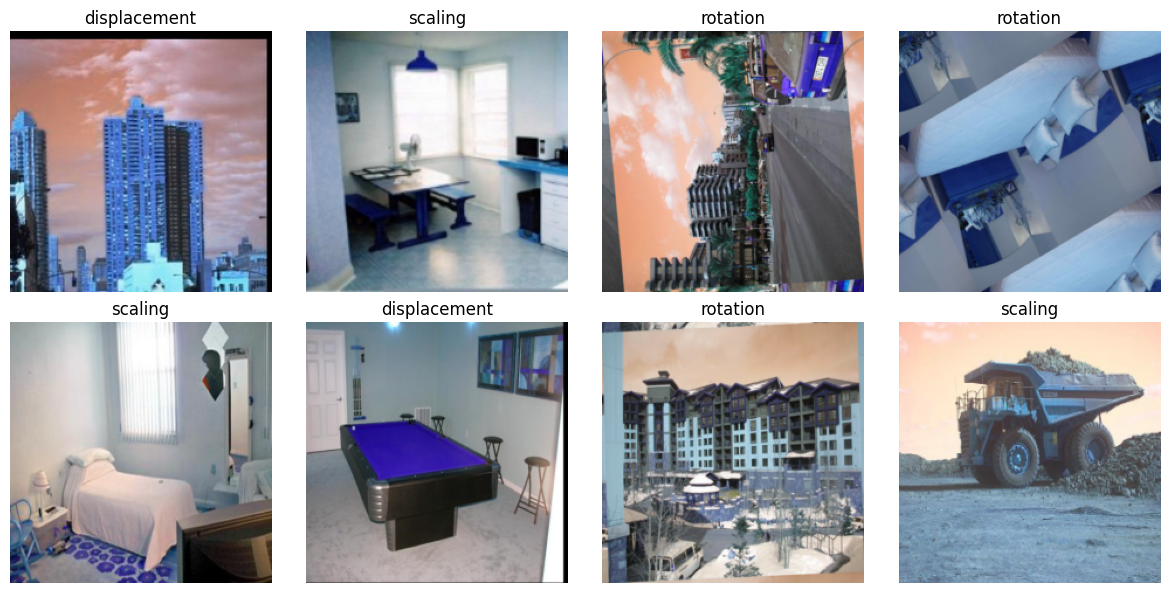

Test Data


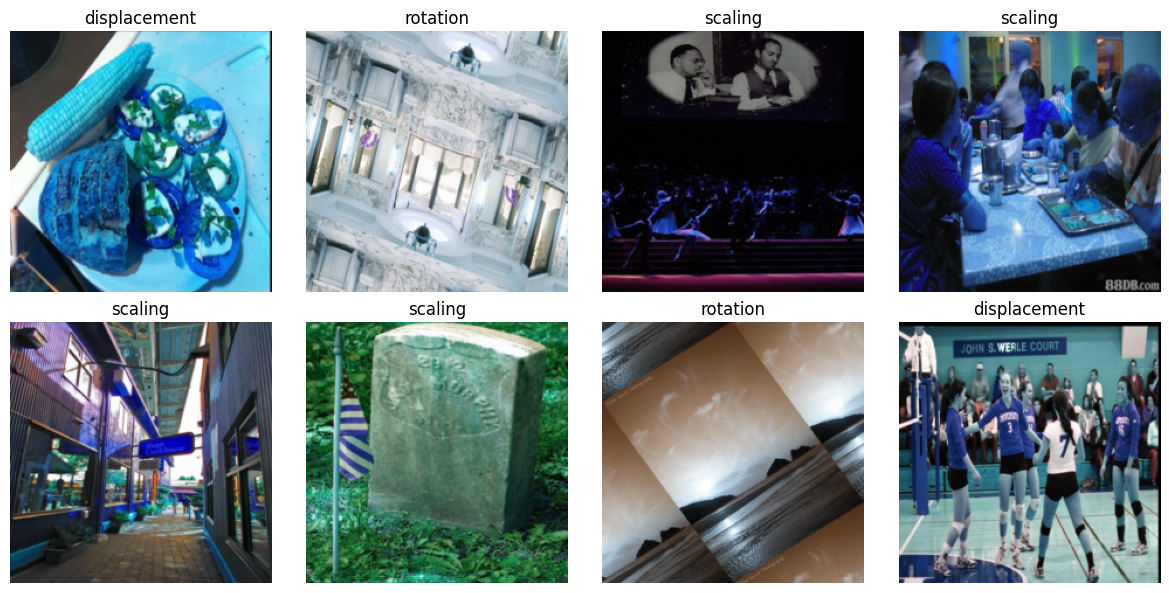

In [7]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

def plot_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(labels[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

train_batch = next(iter(train_loader))
train_images, train_labels = train_batch

test_batch = next(iter(test_loader))
test_images, test_labels = test_batch
print("Train Data")
plot_images(train_images[:8], train_labels[:8])
print("Test Data")
plot_images(test_images[:8], test_labels[:8])

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

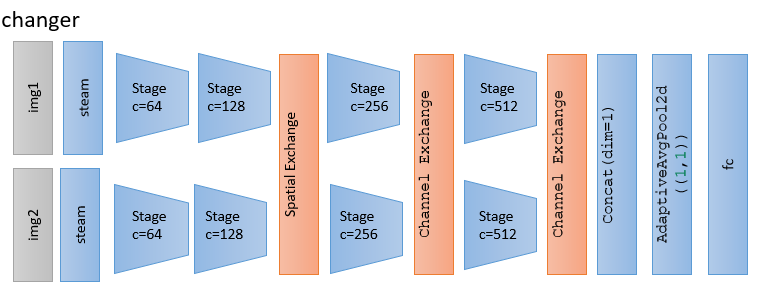

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


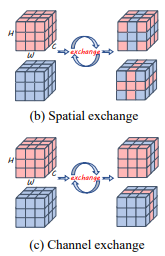

In [8]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

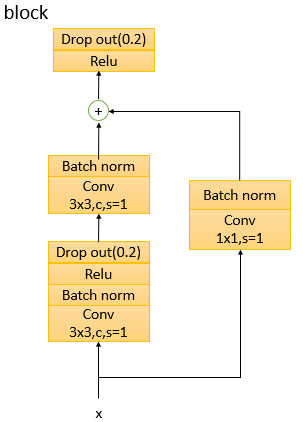

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





سوال1) لایه کانولوشن ورودی آن را به دلیل رنگی بودن برابر با 3 در نظر گرفته شده است و خروجی آن برابر با یک و پدینگ نیز برابر با یک.،
سوال2) با استفاده از یک کانولوشن 1 در 1 باعث کاهش بعد و تبدیل ویژگی میشود. این کرنل یک تبدیل خطی است  که علاوه بر حفظ ابعاد فضایی اطلاعات کانالهای مختلف را نیز ترکیب میکند از طرفی این لایه به شبکه عمق اضافه میکند بدون اضافه کردن بار محاسباتی و طرفیت شبکهه را برای یادگیری افزایش میدهد. 

In [9]:
##To Do
class block(nn.Module):
    def __init__(self,):
        super(block,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(1)
        
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(1)
        
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(p=0.2)


    def forward(self,x):
        out1 = self.dropout1(self.relu1(self.bn1(self.conv1(x))))
        out1 = self.bn2(self.conv2(out1))
        
        out2 = self.bn3(self.conv3(x))
        
        out = out1 + out2
        out = self.dropout2(self.relu2(out))
        
        return out

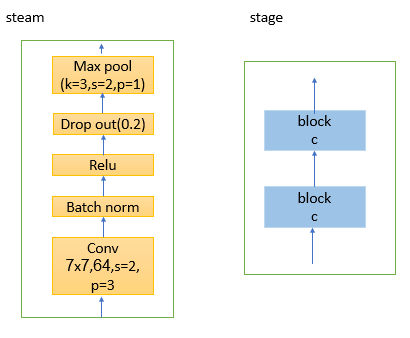

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [10]:
class Changer(nn.Module):
    def __init__(self, block, SpatialExchange, ChannelExchange, num_classes):
        super(Changer, self).__init__()

        self.steam = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = self._make_stage(block, SpatialExchange, ChannelExchange, c=128)  # Adjusted input channels
        self.stage2 = self._make_stage(block, SpatialExchange, ChannelExchange, c=256)  # Adjusted input channels
        self.stage3 = self._make_stage(block, SpatialExchange, ChannelExchange, c=512)  # Adjusted input channels
        self.stage4 = self._make_stage(block, SpatialExchange, ChannelExchange, c=1024)  # Adjusted input channels

        self.spatial_exchange = SpatialExchange()

        self.channel_exchange_1 = ChannelExchange()
        self.channel_exchange_2 = ChannelExchange()

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024 * 2, num_classes)  # Adjusted input size for linear layer

    def _make_stage(self, block, SpatialExchange, ChannelExchange, c):
        layers = [
            block(),
            SpatialExchange(),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c)
        ]
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        out1 = self.steam(x1)
        out2 = self.steam(x2)

        out = torch.cat((out1, out2), dim=1)

        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.spatial_exchange(out)
        out = self.channel_exchange_1(out)

        out = self.stage4(out)
        out = self.channel_exchange_2(out)

        out = torch.cat((out1, out2), dim=1)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [19]:
## To Do
num_epochs = 5
learning_rate = 0.01
num_classes = 3

# Create the model
model = Changer(block, SpatialExchange, ChannelExchange, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##Train & validation


In [20]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        changed_images = batch["changed_images"].to(device)
        real_images = batch["real_images"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(changed_images, real_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

# Show images from train_loader
train_batch = next(iter(train_loader))
train_images, train_labels = train_batch["changed_images"], train_batch["labels"]
print("Train Data")
plot_images(train_images[:8], train_labels[:8])

# Show images from test_loader
test_batch = next(iter(test_loader))
test_images, test_labels = test_batch["changed_images"], test_batch["labels"]
print("Test Data")
plot_images(test_images[:8], test_labels[:8])

TypeError: list indices must be integers or slices, not str

#Test


In [ ]:
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟